# System Identification

In [1]:
import os
import yaml
import casadi as cas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot_utils import make_ioplots, make_ioplots_combined

In [2]:
data_dir = "results"
os.listdir(data_dir)

['sim_results_peak_heat_day_u_prbs2.csv',
 'sim_results_peak_heat_day_u0_0.csv',
 'sim_results_peak_heat_day_u_prbs1.csv',
 'sim_results_peak_heat_day_u0_5.csv',
 'available_inputs.yaml',
 'sim_results_peak_heat_day_u1_0.csv',
 'available_measurements.yaml']

In [3]:
filename = "sim_results_peak_heat_day_u_prbs2.csv"

sim_results = pd.read_csv(os.path.join(data_dir, filename), index_col=0)
sim_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60481 entries, 0 to 60480
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time                    60481 non-null  int64  
 1   time_days               60481 non-null  float64
 2   oveHeaPumY_u            60481 non-null  float64
 3   reaTZon_y               60481 non-null  float64
 4   weaSta_reaWeaHDirNor_y  60481 non-null  float64
 5   weaSta_reaWeaTDryBul_y  60481 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 3.2 MB


In [4]:
sim_results.columns

Index(['time', 'time_days', 'oveHeaPumY_u', 'reaTZon_y',
       'weaSta_reaWeaHDirNor_y', 'weaSta_reaWeaTDryBul_y'],
      dtype='object')

In [5]:
filename = "available_inputs.yaml"
with open(os.path.join(data_dir, filename), 'r') as f:
    available_inputs = yaml.safe_load(f.read())

filename = "available_measurements.yaml"
with open(os.path.join(data_dir, filename), 'r') as f:
    available_measurements = yaml.safe_load(f.read())

In [6]:
sim_results.set_index('time').loc[slice(None, None)]

,time_days,oveHeaPumY_u,reaTZon_y,weaSta_reaWeaHDirNor_y,weaSta_reaWeaTDryBul_y
time,,,,,
777600,9.000000,0.720000,293.150000,0.0,271.250000
777630,9.000347,0.747462,293.108808,0.0,271.249092
777660,9.000694,0.774587,293.068329,0.0,271.248037
777690,9.001042,0.801175,293.028897,0.0,271.246837
777720,9.001389,0.827109,292.990700,0.0,271.245496
...,...,...,...,...,...
2591880,29.998611,0.500000,292.013617,0.0,273.458772
2591910,29.998958,0.500000,292.014879,0.0,273.456542
2591940,29.999306,0.500000,292.016140,0.0,273.454337


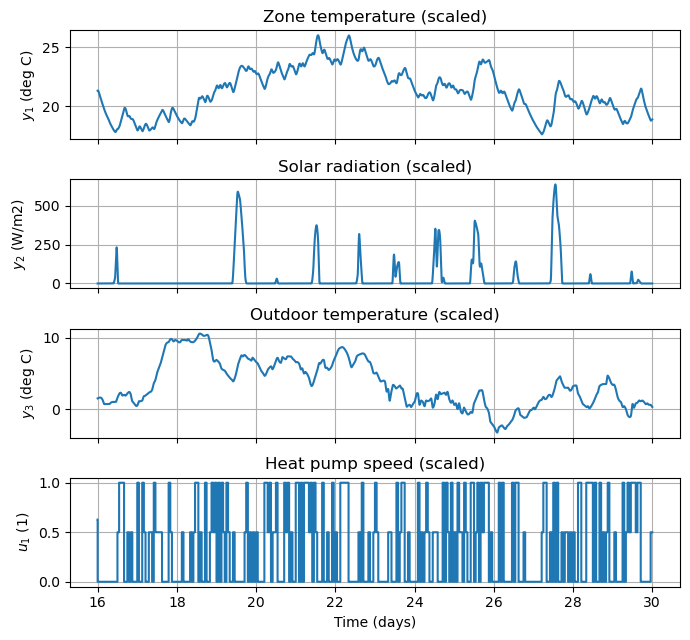

In [7]:
N = sim_results.shape[0] - 1
input_names = ['oveHeaPumY_u']
measurement_names = ['reaTZon_y', 'weaSta_reaWeaHDirNor_y', 'weaSta_reaWeaTDryBul_y']
time_range = slice(16, None)

var_rename_map = {
    'oveHeaPumY_u': 'Heat pump speed (scaled)',
    'reaTZon_y': 'Zone temperature (scaled)', 
    'weaSta_reaWeaHDirNor_y': 'Solar radiation (scaled)', 
    'weaSta_reaWeaTDryBul_y': 'Outdoor temperature (scaled)'
}

fig, axes = make_ioplots(
    sim_results, 
    input_names, 
    measurement_names, 
    available_inputs, 
    available_measurements, 
    time_range=time_range,
    var_rename_map=var_rename_map
)
plt.tight_layout()
plt.show()

In [8]:
# Standardize data

nominal_values = {
    'oveHeaPumY_u': 0.0,
    'reaTZon_y': 273.15 + 20.0, 
    'weaSta_reaWeaHDirNor_y': 0.0, 
    'weaSta_reaWeaTDryBul_y': 273.15 + 0.0
}

scale_factors = {
    'oveHeaPumY_u': 0.1,
    'reaTZon_y': 1.0, 
    'weaSta_reaWeaHDirNor_y': 100.0, 
    'weaSta_reaWeaTDryBul_y': 1.0
}

sim_results_scaled = sim_results[['time', 'time_days']].copy()
for name in measurement_names:
    sim_results_scaled[name] = (sim_results[name] - nominal_values[name]) / scale_factors[name]
for name in input_names:
    sim_results_scaled[name] = (sim_results[name] - nominal_values[name]) / scale_factors[name]

sim_results_scaled.describe()

,time,time_days,reaTZon_y,weaSta_reaWeaHDirNor_y,weaSta_reaWeaTDryBul_y,oveHeaPumY_u
count,6.048100e+04,60481.000000,60481.000000,60481.000000,60481.000000,60481.000000
mean,1.684800e+06,19.500000,1.144611,0.272019,4.180301,3.236828
std,5.237852e+05,6.062328,1.656711,0.896382,3.221328,3.693923
min,7.776000e+05,9.000000,-2.406587,0.000000,-3.305276,0.000000
25%,1.231200e+06,14.250000,0.325497,0.000000,1.423139,0.000000
50%,1.684800e+06,19.500000,1.119687,0.000000,4.159360,1.798515
75%,2.138400e+06,24.750000,1.888271,0.000000,6.721582,5.000000
max,2.592000e+06,30.000000,6.030432,6.387699,10.600581,10.000000


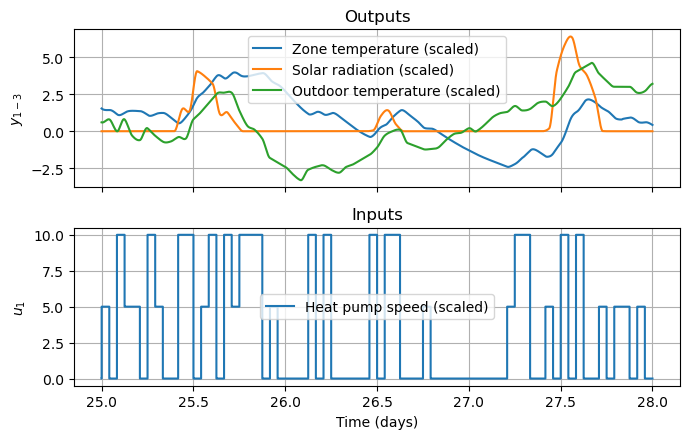

In [9]:
time_range = slice(18.5, 20.5)
time_range = slice(25, 28)

fig, axes = make_ioplots_combined(
    sim_results_scaled, 
    input_names, 
    measurement_names, 
    available_inputs, 
    available_measurements, 
    time_range=time_range,
    var_rename_map=var_rename_map,
)
plt.tight_layout()
plt.show()

## Models

$$
C \frac{d T}{d t}(t) = -H \left( T(t) - T_a(t) \right) + \dot{Q}_h(t) + \dot{Q}_{\text {rad}}(t) + \dot{Q}_{\text {other}}(t)
$$

$$
\dot{Q}_{\text {rad}}(t) = k_R R(t)
$$

In [10]:
# Parameters
C = 6.0  # thermal capacitance, kWh/°C
H = 6/24   # scaled heat transfer coefficient with ambient, kW/°C
k_rad = 1.0  # unknown constant relating measured solar radiation and heat input to zone

# System dimensions
n_x = 1  # number of states
n_u = 1  # number of manipulated inputs
n_p = 2  # number of disturbance inputs

# Declare variables
x = cas.MX.sym('x', n_x)  # states
u = cas.MX.sym('u', n_u)  # manipulated inputs
p = cas.MX.sym('p', n_p)  # disturbance inputs

# Aliases
T = x[0]  # zone temperature
Q_c = u[0]  # cooling delivered
T_a = p[0]  # ambient temperature
R = p[1]  # solar insolation

# Define ODE
dTdt = (-H * (T - T_a) - Q_c + k_rad * R) / C  # rate-of-change of zone temperature
inputs = cas.vertcat(u, p)
rhs = dTdt
f = cas.Function('f', [x, inputs], [rhs], ['x', 'inputs'], ['dxdt'])
print(f)

f:(x,inputs[3])->(dxdt) MXFunction
